In [0]:
'''
Input: 32x32 mesh simulation
Target: 64x64 mesh simulation
Downsampled skip connection multi scale model with reflection padding
'''

In [0]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
import torchvision
import torch.utils.data
import torch.nn.functional as F
import torch.nn.init as init

In [0]:
#Reading training data
train_y = []
train_x = []

for i in range(1, 101, 1):
    temperature = "{:.2f}".format(0.01 * i)
    
    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
       
    x_input = [u,v,pressure]
    train_x.append(x_input)

    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    y_output = [u,v,pressure]
    train_y.append(y_output)

In [0]:
#Reading validation data

val_y = []
val_x = []

for i in range(1, 20, 2):
    temperature = 0.05 * i + 0.005
    temperature = "{:.3f}".format(temperature)
    
    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    x_input = [u,v,pressure]
    val_x.append(x_input)

    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    y_output = [u,v,pressure]
    val_y.append(y_output)
    
    
    temperature = 0.05 * i - 0.005
    temperature = "{:.3f}".format(temperature)
    
    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
   
    x_input = [u,v,pressure]
    val_x.append(x_input)

    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    y_output = [u,v,pressure]
    val_y.append(y_output)

In [0]:
def show(image):
    plt.imshow(image, vmin=np.amin(image), vmax=np.amax(image), cmap='hsv')
    plt.axis('off')
    plt.show()

In [0]:
from torch.utils.data import Dataset
class dataset(Dataset):
    def __init__(self, train_x, train_y):
        self.x = train_x
        self.y = train_y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [0]:
train_data_x = []
val_data_x = []

for i in range(len(train_x)):
    u = cv2.resize(np.asarray(train_x[i][0]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    v = cv2.resize(np.asarray(train_x[i][1]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    pressure = cv2.resize(np.asarray(train_x[i][2]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    
    train_data_x.append(np.asarray([u,v,pressure]))
    
for i in range(len(val_x)):
    u = cv2.resize(np.asarray(val_x[i][0]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    v = cv2.resize(np.asarray(val_x[i][1]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    pressure = cv2.resize(np.asarray(val_x[i][2]), dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
    
    val_data_x.append(np.asarray([u,v,pressure]))

In [0]:
#Resize from 64x64 to 104x104
new_train_x = []
new_val_x = []    
    
for i in range(len(train_data_x)):
    data_point = []
    for channel in range(3):
        x = train_data_x[i][channel]
        z = [[0.0 for j in range(104)] for k in range(104)]
        for j in range(20,84,1):
          for k in range(20,84,1):
            z[j][k] = x[j-20][k-20]

        for j in range(20):
          for k in range(20):
            z[j][k] = z[39-j][39-k]
            
        for j in range(84,104,1):
          for k in range(20):
            z[j][k] = z[167-j][39-k]
            
        for j in range(20):
          for k in range(84,104,1):
            z[j][k] = z[39-j][167-k]
            
        for j in range(84,104,1):
          for k in range(84,104,1):
            z[j][k] = z[167-j][167-k]

        for j in range(20):
          for k in range(20,84,1):
            z[j][k] = z[39-j][k]
            
        for j in range(84,104,1):
          for k in range(20,84,1):
            z[j][k] = z[167-j][k]

        for j in range(20,84,1):
          for k in range(20):
            z[j][k] = z[j][39-k]
            
        for j in range(20,84,1):
          for k in range(84,104,1):
            z[j][k] = z[j][167-k]
            
        data_point.append(z)
    new_train_x.append(np.asarray(data_point))  
  
for i in range(len(val_data_x)):
    data_point = []
    for channel in range(3):
        x = val_data_x[i][channel]
        z = [[0.0 for j in range(104)] for k in range(104)]
        for j in range(20,84,1):
          for k in range(20,84,1):
            z[j][k] = x[j-20][k-20]

        for j in range(20):
          for k in range(20):
            z[j][k] = z[39-j][39-k]
            
        for j in range(84,104,1):
          for k in range(20):
            z[j][k] = z[167-j][39-k]
            
        for j in range(20):
          for k in range(84,104,1):
            z[j][k] = z[39-j][167-k]
            
        for j in range(84,104,1):
          for k in range(84,104,1):
            z[j][k] = z[167-j][167-k]

        for j in range(20):
          for k in range(20,84,1):
            z[j][k] = z[39-j][k]
            
        for j in range(84,104,1):
          for k in range(20,84,1):
            z[j][k] = z[167-j][k]

        for j in range(20,84,1):
          for k in range(20):
            z[j][k] = z[j][39-k]
            
        for j in range(20,84,1):
          for k in range(84,104,1):
            z[j][k] = z[j][167-k]
            
        data_point.append(z)
    new_val_x.append(np.asarray(data_point))    

In [0]:
train_data_x = np.asarray(train_data_x)    
train_y = np.asarray(train_y)    
val_data_x = np.asarray(val_data_x)    
val_y = np.asarray(val_y)    
    
train_data = dataset(new_train_x, train_y)
val_data = dataset(new_val_x, val_y)

In [0]:
activate = torch.nn.Tanh()
tanh = torch.nn.Tanh()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.bn0 = nn.BatchNorm2d(num_features = 3)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 2, stride = 2, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 2, stride = 2, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 2, stride = 2, padding = 0)
        self.conv4 = nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, output_padding=0)
        self.conv5 = nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, output_padding=0)
        self.conv6 = nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, output_padding=0)
        
        #kernel_size 13
        self.bn7 = nn.BatchNorm2d(num_features = 3)
        self.conv7 = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 13, stride = 1, padding = 0)
        self.bn8 = nn.BatchNorm2d(num_features = 4)
        self.conv8 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 13, stride = 1, padding = 0)
        #kernel_size 9
        self.bn9 = nn.BatchNorm2d(num_features = 3)
        self.conv9  = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 9, stride = 1, padding = 0)
        self.bn10 = nn.BatchNorm2d(num_features = 4)
        self.conv10 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 9, stride = 1, padding = 0)
        #kernel_size 5
        self.bn11 = nn.BatchNorm2d(num_features = 3)
        self.conv11 = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 5, stride = 1, padding = 0)
        self.bn12 = nn.BatchNorm2d(num_features = 4)
        self.conv12 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 5, stride = 1, padding = 0)
        #last conv layer
        self.bn13 = nn.BatchNorm2d(num_features = 24)
        self.conv13 = nn.Conv2d(in_channels = 24, out_channels = 12, kernel_size = 7, stride = 1, padding = 0)
        self.bn14 = nn.BatchNorm2d(num_features = 12)
        self.conv14 = nn.Conv2d(in_channels = 12, out_channels =  3, kernel_size = 5, stride = 1, padding = 0)
        #Final output layer
        self.bn_out = nn.BatchNorm2d(num_features = 3)
        self.out = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 0)
        
    def forward(self, x_64):
        
        x_32 = activate(self.conv1(x_64))
        x_16 = activate(self.conv2(x_32))
        x_8  = activate(self.conv3(x_16))        
        y_16 = activate(self.conv4(x_8))+x_16
        y_32 = activate(self.conv5(y_16))+x_32
        y_64 = activate(self.conv6(y_32))+x_64
        
        z_13 = self.bn7(x_64)
        z_13 = self.conv7(z_13)
        z_13 = activate(z_13)
        z_13 = self.bn8(z_13)
        z_13 = self.conv8(z_13)
        z_13 = activate(z_13)
        
        z_9 = self.bn9(x_64)
        z_9 = self.conv9(z_9)
        z_9 = activate(z_9)
        z_9 = self.bn10(z_9)
        z_9 = self.conv10(z_9)
        z_9 = activate(z_9)
        
        z_5 = self.bn11(x_64)
        z_5 = self.conv11(z_5)
        z_5 = activate(z_5)
        z_5 = self.bn12(z_5)
        z_5 = self.conv12(z_5)
        z_5 = activate(z_5)
        
        z_5 = z_5.narrow(2,10,76)
        z_5 = z_5.narrow(3,10,76)
        
        z_9 = z_9.narrow(2,6,76)
        z_9 = z_9.narrow(3,6,76)
        
        z_13 = z_13.narrow(2,2,76)
        z_13 = z_13.narrow(3,2,76)
        
        z = torch.cat((z_13, z_9, z_5), 1)
        z = self.bn13(z)
        z = self.conv13(z)
        z = activate(z)
        z = self.bn14(z)
        z = self.conv14(z)
        z = activate(z)
        
        y_64 = y_64.narrow(2,19,66)
        y_64 = y_64.narrow(3,19,66)
        
        x_64 = x_64.narrow(2,20,64)
        x_64 = x_64.narrow(3,20,64)
        
        z = z+y_64
        z = self.bn_out(z)
        z = self.out(z)
        z = tanh(z)+x_64.resize_(1,3,64,64)
       
        return z

In [0]:
def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle = True)
test_loader = torch.utils.data.DataLoader(val_data, batch_size = 1, shuffle = False)

In [0]:
criterion = nn.MSELoss()
net = Net()
net.apply(weight_init)
net = net.double()
net = net.cuda()
train_losses = []
val_losses = []

In [0]:
learning_rate = 0.05
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
#optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = 1e-5)

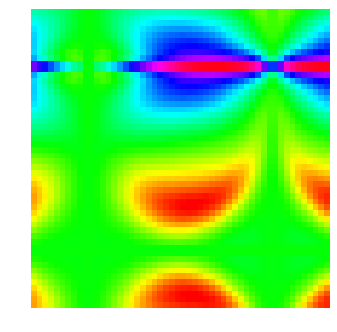

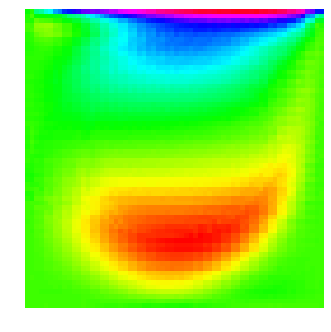

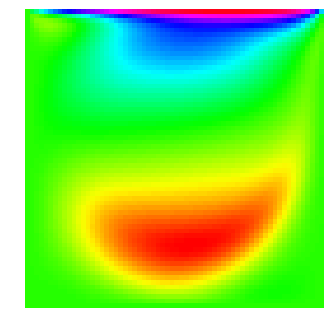

Epoch:  1  running_loss:  0.005203737999972952 validation_loss:  0.004833529607910744
Epoch:  2  running_loss:  0.005132250317126891 validation_loss:  0.005444081874594185
Epoch:  3  running_loss:  0.0052104106433324615 validation_loss:  0.005372100070053952
Epoch:  4  running_loss:  0.005189649649668346 validation_loss:  0.005380125835930097
Epoch:  5  running_loss:  0.005178773663095615 validation_loss:  0.005575270557341221
Epoch:  6  running_loss:  0.005091568216867902 validation_loss:  0.004874211403426481
Epoch:  7  running_loss:  0.005173350660749242 validation_loss:  0.0048186656924976866
Epoch:  8  running_loss:  0.005176045345464256 validation_loss:  0.00487462669176032
Epoch:  9  running_loss:  0.00515452545104653 validation_loss:  0.005319991622208438
Epoch:  10  running_loss:  0.005163328642942573 validation_loss:  0.005164216611703104
Epoch:  11  running_loss:  0.005083201032322005 validation_loss:  0.004997151142537088
Epoch:  12  running_loss:  0.005055873322895387 vali

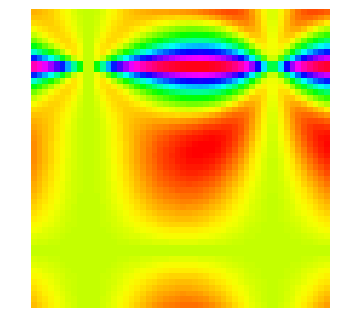

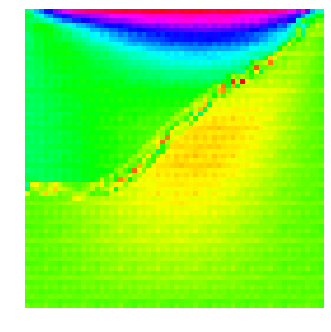

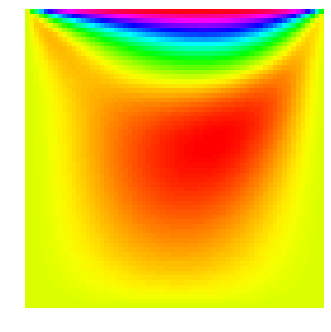

Epoch:  26  running_loss:  0.005203831838719966 validation_loss:  0.005359356887688957
Epoch:  27  running_loss:  0.005146068404669609 validation_loss:  0.0051285163148864915
Epoch:  28  running_loss:  0.005084440504358736 validation_loss:  0.005303428204502429
Epoch:  29  running_loss:  0.005197754231774022 validation_loss:  0.005055359815884383
Epoch:  30  running_loss:  0.005111070025369861 validation_loss:  0.00526804064393661
Epoch:  31  running_loss:  0.005115768203585846 validation_loss:  0.005122777745612831
Epoch:  32  running_loss:  0.00530509987370189 validation_loss:  0.005080141256844758
Epoch:  33  running_loss:  0.005139602358833997 validation_loss:  0.005034568550365739
Epoch:  34  running_loss:  0.005083127880303062 validation_loss:  0.005262829803216805
Epoch:  35  running_loss:  0.005214123465774597 validation_loss:  0.004819857329758951
Epoch:  36  running_loss:  0.005098095263609564 validation_loss:  0.00496361809436901
Epoch:  37  running_loss:  0.0051370568093910

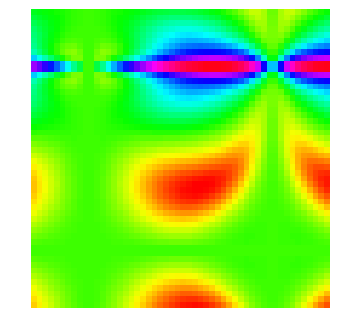

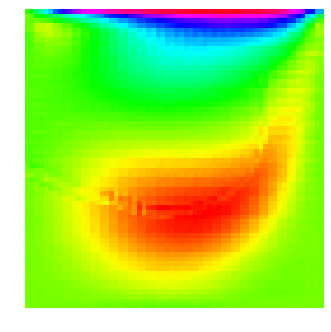

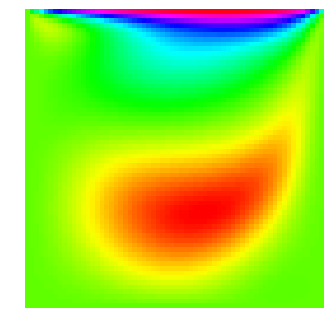

Epoch:  51  running_loss:  0.00520148163014181 validation_loss:  0.005220311515525595
Epoch:  52  running_loss:  0.005117761464978368 validation_loss:  0.004959445830019062
Epoch:  53  running_loss:  0.005054045583240709 validation_loss:  0.005065733546355965
Epoch:  54  running_loss:  0.005140614787399897 validation_loss:  0.005174155836567022
Epoch:  55  running_loss:  0.005119300556432828 validation_loss:  0.00523435056226675
Epoch:  56  running_loss:  0.005196428964187359 validation_loss:  0.005030212068249003
Epoch:  57  running_loss:  0.005124323758405227 validation_loss:  0.005011797767683832
Epoch:  58  running_loss:  0.005158267872730346 validation_loss:  0.0048786011151600575
Epoch:  59  running_loss:  0.005107628989101749 validation_loss:  0.005176346291524323
Epoch:  60  running_loss:  0.005154356615696422 validation_loss:  0.00520818530615103
Epoch:  61  running_loss:  0.0052039563145141 validation_loss:  0.004812328480940417
Epoch:  62  running_loss:  0.005199989423659929

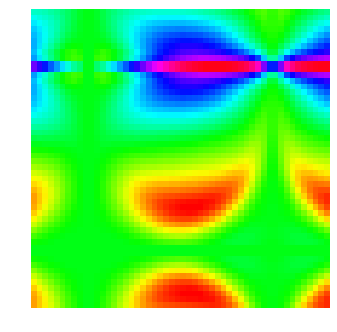

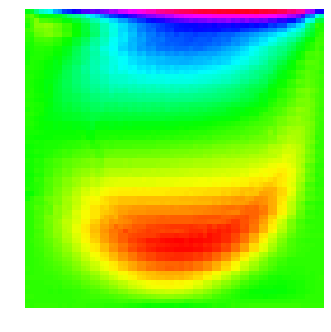

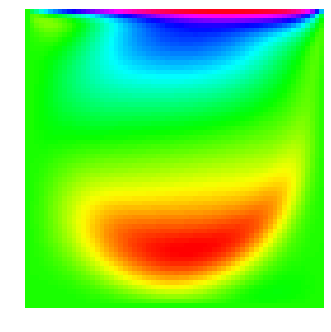

Epoch:  76  running_loss:  0.005108248289713356 validation_loss:  0.005307397593850579
Epoch:  77  running_loss:  0.0051732621482786945 validation_loss:  0.0049409732502065686
Epoch:  78  running_loss:  0.005122084430981976 validation_loss:  0.004788594179669187
Epoch:  79  running_loss:  0.005126274843743914 validation_loss:  0.00522328772483378


KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

running_loss = 0.0
num_epochs = 1201

for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss = 0.0
    #print("Epoch: ",epoch+1)
    for i, dat in enumerate((train_loader), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 3, 104, 104)
        labels = labels.resize_(1, 3, 64, 64)
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        if(i==9 and epoch%25==0):
            show(inputs[0][0].cpu().detach().numpy())
            show(outputs[0][0].cpu().detach().numpy())
            show(labels[0][0].cpu().detach().numpy())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    for i, dat in enumerate((test_loader), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 3, 104, 104)
        labels = labels.resize_(1, 3, 64, 64)
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.step()
        validation_loss += loss.item()
    running_loss/=100.0
    validation_loss/=20.0
    print("Epoch: ",epoch+1," running_loss: ",running_loss*100, "validation_loss: ",validation_loss*100.0)
    train_losses.append(running_loss)
    val_losses.append(validation_loss)

In [0]:
from google.colab import files
torch.save(net.state_dict(),'weights.pth')
files.download('weights.pth')

In [0]:
net.load_state_dict(torch.load("weights.pth"))

In [0]:
train_losses = np.asarray(train_losses)
val_losses = np.asarray(val_losses)
np.savetxt('train.txt', train_losses, delimiter = '\t')
np.savetxt('val.txt', val_losses, delimiter = '\t')
from google.colab import files
files.download('train.txt')
files.download('val.txt')